In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandasql import sqldf
pysqldf = lambda q:sqldf(q,globals())

In [66]:
#pd.read_csv?
df = pd.read_csv(r'./athlete_events.csv',index_col='ID')

In [67]:
df.head(5)

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [68]:
df.describe()

,Age,Height,Weight,Year
count,261642.000000,210945.000000,208241.000000,271116.000000
mean,25.556898,175.338970,70.702393,1978.378480
std,6.393561,10.518462,14.348020,29.877632
min,10.000000,127.000000,25.000000,1896.000000
25%,21.000000,168.000000,60.000000,1960.000000
50%,24.000000,175.000000,70.000000,1988.000000
75%,28.000000,183.000000,79.000000,2002.000000
max,97.000000,226.000000,214.000000,2016.000000


In [69]:
df_noc = pd.read_csv(r'./noc_regions.csv')
df_noc.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [70]:
df['Year']=pd.to_datetime(df['Year'],format='%Y').dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 1 to 135571
Data columns (total 14 columns):
Name      271116 non-null object
Sex       271116 non-null object
Age       261642 non-null float64
Height    210945 non-null float64
Weight    208241 non-null float64
Team      271116 non-null object
NOC       271116 non-null object
Games     271116 non-null object
Year      271116 non-null int64
Season    271116 non-null object
City      271116 non-null object
Sport     271116 non-null object
Event     271116 non-null object
Medal     39783 non-null object
dtypes: float64(3), int64(1), object(10)
memory usage: 31.0+ MB


In [71]:
medal_count=pysqldf('''
SELECT Medal
    ,count(*) AS Medal_count
FROM df
Where Medal != "None"
GROUP BY Medal
''')
medal_count

,Medal,Medal_count
0,Bronze,13295
1,Gold,13372
2,Silver,13116


In [72]:
df.isnull().sum()

Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023FBCF23F08>]],
      dtype=object)

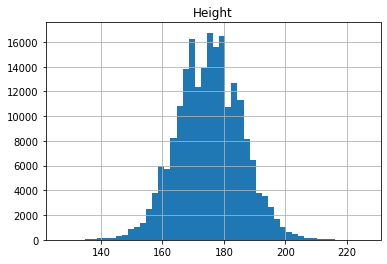

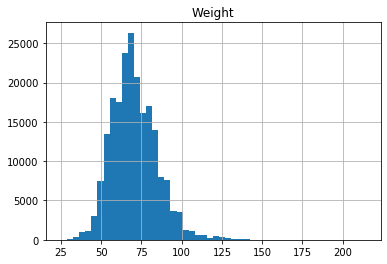

In [73]:
df.hist('Height',bins=50)
df.hist('Weight',bins=50)

In [65]:
df['Age'].fillna(value=df['Age'].mode()[0],inplace=True)
df['Height'].fillna(value=df['Height'].mean(),inplace=True)
df['Weight'].fillna(value=df['Weight'].mean(),inplace=True)
df.isnull().sum()

Name                    0
Sex                     0
Age                     0
Height                  0
Weight                  0
Team                    0
NOC                     0
Games                   0
Year                    0
Season                  0
City                    0
Sport                   0
Event                   0
Medal              231333
Event By Gender         0
dtype: int64

In [11]:
pysqldf('''SELECT MIN(year)
FROM df''')

,MIN(year)
0,1896


In [77]:
more_participants = pysqldf('''
SELECT Year
    ,SUM(CASE WHEN Sex='M' THEN 1 ELSE 0 END) AS male_count
    ,SUM(CASE WHEN Sex='F' THEN 1 ELSE 0 END) AS female_count
FROM df
GROUP BY Year
ORDER BY Year ASC
''')
more_participants.head()

,Year,male_count,female_count
0,1896,380,0
1,1900,1903,33
2,1904,1285,16
3,1906,1722,11
4,1908,3054,47


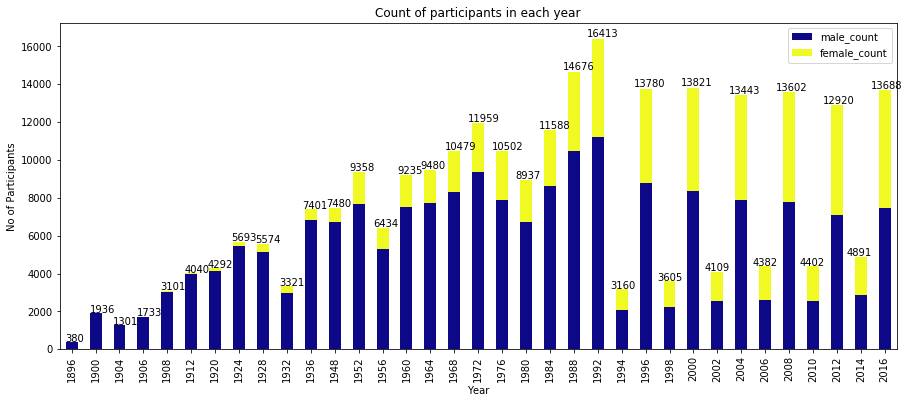

In [91]:
ax=more_participants.plot(kind='bar',x='Year',y=['male_count','female_count'],stacked=True,cmap='plasma',figsize=(15,6))
ax.set_ylabel('No of Participants')
ax.set_title('Count of participants in each year')
d = dict()
for bar in ax.patches:
    h = d.get(bar.get_x(),0)
    h+=bar.get_height()
    if h!=bar.get_height():
        ax.annotate(int(h),(bar.get_x()*0.99,h*1.005))
    else: d[bar.get_x()]=h

In [14]:
top_10=pysqldf('''
SELECT ID
    ,Name
    ,COUNT(*) as Count
FROM df
WHERE Medal IS NOT NULL
GROUP BY ID
ORDER BY Count DESC
LIMIT 10
''')
top_10

,ID,Name,Count
0,94406,"Michael Fred Phelps, II",28
1,67046,Larysa Semenivna Latynina (Diriy-),18
2,4198,Nikolay Yefimovich Andrianov,15
3,11951,Ole Einar Bjrndalen,13
4,74420,Edoardo Mangiarotti,13
5,89187,Takashi Ono,13
6,109161,Borys Anfiyanovych Shakhlin,13
7,23426,Natalie Anne Coughlin (-Hall),12
8,35550,Birgit Fischer-Schmidt,12
9,57998,Sawao Kato,12


In [15]:
gender_stats = pysqldf('''
SELECT Sex
    ,COUNT(*) AS count
FROM df
GROUP BY Sex
ORDER BY Sex DESC
''')
gender_stats

,Sex,count
0,M,196594
1,F,74522


In [16]:
gender_contribution = pysqldf('''
SELECT Sex
    ,COUNT(*) AS count
FROM df
WHERE Medal IS NOT NULL
GROUP BY Sex
ORDER BY Sex DESC
''')
gender_contribution

,Sex,count
0,M,28530
1,F,11253


In [17]:
Medal_Contribution = pysqldf('''
SELECT Sex
    ,SUM(CASE WHEN Medal='Gold' THEN 1 ELSE 0 END) AS Gold
    ,SUM(CASE WHEN Medal='Silver' THEN 1 ELSE 0 END) AS Silver
    ,SUM(CASE WHEN Medal='Bronze' THEN 1 ELSE 0 END) AS Bronze
FROM df
WHERE Medal IS NOT NULL
GROUP BY Sex
ORDER BY Sex DESC
''')
Medal_Contribution

,Sex,Gold,Silver,Bronze
0,M,9625,9381,9524
1,F,3747,3735,3771


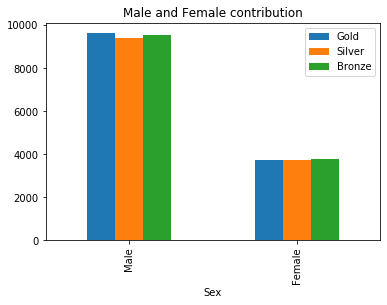

In [18]:
ax=Medal_Contribution.plot(kind='bar',x='Sex',title="Male and Female contribution")
_=ax.set_xticklabels(['Male','Female'])

In [19]:
def get_medal_ratio():
    print('Male Contribution: ',gender_contribution[gender_contribution['Sex']=='M']['count']/gender_stats[gender_stats['Sex'] == 'M']['count'])
    print('Female Contribution: ',gender_contribution[gender_contribution['Sex']=='F']['count']/gender_stats[gender_stats['Sex'] == 'F']['count'])    
get_medal_ratio()

Male Contribution:  0    0.145121
Name: count, dtype: float64
Female Contribution:  1    0.151002
Name: count, dtype: float64


In [94]:
medals_by_country = pysqldf(
'''
SELECT region
    ,df.NOC AS NOC
    ,SUM(CASE WHEN Medal='Gold' THEN 1 ELSE 0 END) AS Gold
    ,SUM(CASE WHEN Medal='Silver' THEN 1 ELSE 0 END) AS Silver
    ,SUM(CASE WHEN Medal='Bronze' THEN 1 ELSE 0 END) AS Bronze
    ,COUNT(*) AS `Total Count`
FROM df JOIN df_noc
ON df.NOC = df_noc.NOC
WHERE Medal IS NOT NULL
GROUP BY region
ORDER BY `Total Count` DESC
''')
medals_by_country.head(10)

,region,NOC,Gold,Silver,Bronze,Total Count
0,USA,USA,2638,1641,1358,5637
1,Russia,RUS,1599,1170,1178,3947
2,Germany,GDR,1301,1195,1260,3756
3,UK,GBR,678,739,651,2068
4,France,FRA,501,610,666,1777
5,Italy,ITA,575,531,531,1637
6,Sweden,SWE,479,522,535,1536
7,Canada,CAN,463,438,451,1352
8,Australia,AUS,368,459,522,1349
9,Hungary,HUN,432,332,371,1135


World map showing number of medals won by each country over range of colours.  
![Medals](Country_Medals.png)

In [21]:
#medals_by_country.to_csv(r'C:\Users\Nihal\Naveen\myPythonScripts\sql\country_medals.csv')

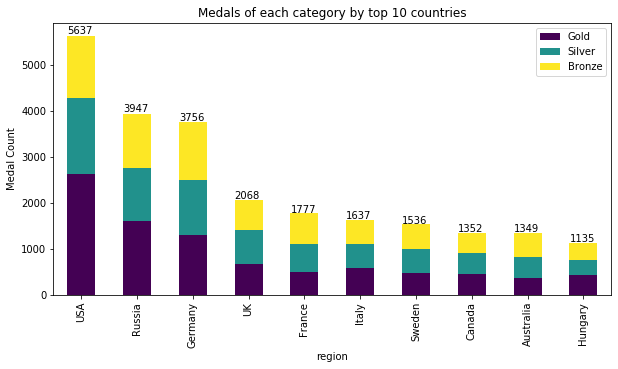

In [143]:
ax=medals_by_country.head(10).plot(kind='bar',x='region',y=['Gold','Silver','Bronze'],stacked=True,cmap='viridis',figsize=(10,5))
ax.set_title('Medals of each category by top 10 countries')
ax.set_ylabel('Medal Count')
d = {}
for bar in ax.patches:
    h=d.get(bar.get_x(),0)
    h+=bar.get_height()
    d[bar.get_x()]=h
for x,y in d.items():
    ax.annotate(int(y),(x,y*1.01))

In [23]:
medals_us_india = pysqldf(
'''
SELECT region
    ,df.NOC AS NOC
    ,SUM(CASE WHEN Medal='Gold' THEN 1 ELSE 0 END) AS Gold
    ,SUM(CASE WHEN Medal='Silver' THEN 1 ELSE 0 END) AS Silver
    ,SUM(CASE WHEN Medal='Bronze' THEN 1 ELSE 0 END) AS Bronze
    ,COUNT(*) AS `Total Count`
FROM df JOIN df_noc
ON df.NOC = df_noc.NOC
WHERE Medal IS NOT NULL AND df.NOC IN ("IND","USA")
GROUP BY region,df.NOC
''')
medals_us_india

,region,NOC,Gold,Silver,Bronze,Total Count
0,India,IND,138,19,40,197
1,USA,USA,2638,1641,1358,5637


In [24]:
print("Medals won by USA are",medals_us_india.iloc[1,-1]//medals_us_india.iloc[0,-1], "times more than India")

Medals won by USA are 28 times more than India


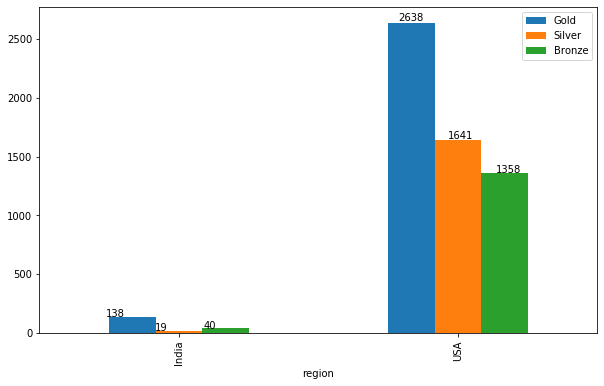

In [25]:
ax=medals_us_india.plot(kind='bar',x='region',y=['Gold','Silver','Bronze'],figsize=(10,6))
for bar in ax.patches:
    ax.annotate(bar.get_height(),(bar.get_x()*1.05,bar.get_height()*1.005))

In [26]:
sport_participants = pysqldf('''
SELECT Sport
    ,Year
    ,COUNT(*) AS count
FROM df
GROUP BY Sport,Year
ORDER BY Sport,Year
''')
sport_participants

,Sport,Year,count
0,Aeronautics,1936,1
1,Alpine Skiing,1936,103
2,Alpine Skiing,1948,360
3,Alpine Skiing,1952,378
4,Alpine Skiing,1956,403
...,...,...,...
901,Wrestling,2000,314
902,Wrestling,2004,342
903,Wrestling,2008,343
904,Wrestling,2012,339


In [27]:
#sport_participants.to_csv(r'C:\Users\Nihal\Naveen\myPythonScripts\sql\sport_participants.csv')

Interactive Visualisation of number of participants participate each year for a given sport.

Top 3 sport trends are:  
1.Athletics  
2.Swimming  
3.Gymnastics
![Sport Trends](Sport.png)

In [28]:
sport_by_country = pysqldf('''
SELECT region
    ,NOC
    ,CASE WHEN Medal_Count = MAX(Medal_Count) THEN Sport
    ELSE NULL END AS Sport
    ,Medal_Count
FROM
(SELECT region
    ,df.NOC AS NOC
    ,Sport
    ,COUNT(*) AS Medal_Count
FROM df
JOIN df_noc
ON df.NOC = df_noc.NOC
WHERE Medal IS NOT NULL
GROUP BY Team,df.NOC,Sport
ORDER BY region) dd
GROUP BY region,NOC
ORDER BY Medal_Count DESC
LIMIT 10
''')
sport_by_country

,region,NOC,Sport,Medal_Count
0,USA,USA,Athletics,1071
1,Australia,AUS,Swimming,401
2,Italy,ITA,Fencing,359
3,Canada,CAN,Ice Hockey,348
4,UK,GBR,Athletics,334
5,France,FRA,Fencing,310
6,Russia,URS,Gymnastics,288
7,Netherlands,NED,Hockey,255
8,Hungary,HUN,Fencing,236
9,Sweden,SWE,Ice Hockey,217


In [29]:
sport_by_country.to_csv(r'C:\Users\Nihal\Naveen\myPythonScripts\sql\temp.csv')

In [30]:
season_stats = pysqldf('''
SELECT region
    ,df.NOC AS NOC
    ,SUM(CASE WHEN Season='Summer' THEN 1 ELSE 0 END) AS summer
    ,SUM(CASE WHEN Season='Winter' THEN 1 ELSE 0 END) AS winter
    ,COUNT(*) AS `Total count`
FROM df
JOIN df_noc
ON df.NOC = df_noc.NOC
WHERE Medal IS NOT NULL 
GROUP BY region
''')
season_stats

,region,NOC,summer,winter,Total count
0,Afghanistan,AFG,2,0,2
1,Algeria,ALG,17,0,17
2,Argentina,ARG,274,0,274
3,Armenia,ARM,16,0,16
4,Australia,AUS,1333,16,1349
...,...,...,...,...,...
131,Venezuela,VEN,15,0,15
132,Vietnam,VIE,4,0,4
133,"Virgin Islands, US",ISV,1,0,1
134,Zambia,ZAM,2,0,2


In [31]:
season_stats.to_csv(r'C:\Users\Nihal\Naveen\myPythonScripts\sql\season_stats.csv')

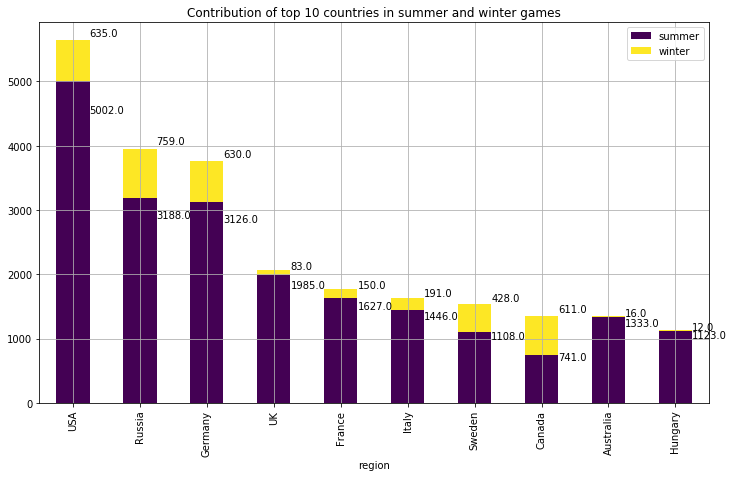

In [32]:
ax=season_stats.sort_values('Total count',ascending =False).head(10).plot(kind='bar',x='region',y=['summer','winter'],stacked=True,
                                                                       title="Contribution of top 10 countries in summer and winter games",cmap='viridis',grid=True,figsize=(12,7))
x_val= dict()
for bar in ax.patches:
    h=x_val.get(bar.get_x(),0)
    ax.annotate(bar.get_height(),(bar.get_x()+1/2,h+bar.get_height()*.90 if h==0 else h+bar.get_height()*1.1))
    x_val[bar.get_x()]=h+bar.get_height()

In [ ]:
ss = pysqldf('''
SELECT Year
    ,Season
FROM df
GROUP BY Year,Season
ORDER by Year''')
ss.head()

In [113]:
participants_by_season =pysqldf('''
SELECT Year
    ,SUM(CASE WHEN Season='Summer' THEN 1 ELSE 0 END) AS Summer
    ,SUM(CASE WHEN Season='Winter' THEN 1 ELSE 0 END) AS Winter
from df
GROUP BY Year
ORDER BY Year
''')
participants_by_season

,Year,Summer,Winter
0,1896,380,0
1,1900,1936,0
2,1904,1301,0
3,1906,1733,0
4,1908,3101,0
5,1912,4040,0
6,1920,4292,0
7,1924,5233,460
8,1928,4992,582
9,1932,2969,352


Text(0, 0.5, 'Participants')

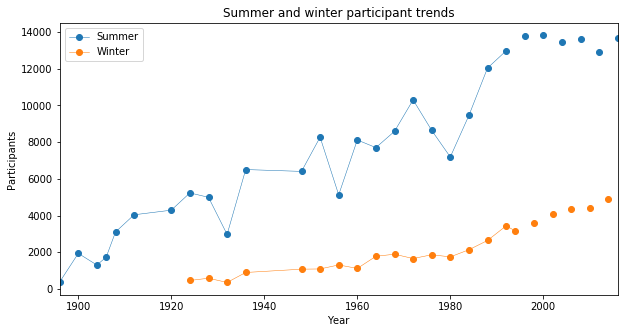

In [131]:
participants_by_season.replace(0,np.nan,inplace=True)
ax=participants_by_season.plot(kind='line',x='Year',y=['Summer','Winter'],title='Summer and winter participant trends',marker='o',lw=0.5,figsize=(10,5))
ax.set_ylabel('Participants')

In [34]:
participants_by_year =pysqldf('''
SELECT Year
    ,SUM(CASE WHEN Sex='M' AND Season='Summer' THEN 1 ELSE 0 END) AS `Male Summer`
    ,SUM(CASE WHEN Sex='M' AND Season='Winter' THEN 1 ELSE 0 END) AS `Male Winter`
    ,SUM(CASE WHEN Sex='F' AND Season='Summer' THEN 1 ELSE 0 END) AS `Female Summer`
    ,SUM(CASE WHEN Sex='F' AND Season='Winter' THEN 1 ELSE 0 END) AS `Female Winter`
FROM df
GROUP BY Year
ORDER BY Year
''')
participants_by_year

,Year,Male Summer,Male Winter,Female Summer,Female Winter
0,1896,380,0,0,0
1,1900,1903,0,33,0
2,1904,1285,0,16,0
3,1906,1722,0,11,0
4,1908,3054,0,47,0
5,1912,3953,0,87,0
6,1920,4158,0,134,0
7,1924,4989,443,244,17
8,1928,4588,549,404,33
9,1932,2622,330,347,22


In [132]:
participants_by_year.replace(0,np.nan,inplace=True)

Text(0, 0.5, 'Sex Ratio (M/F)')

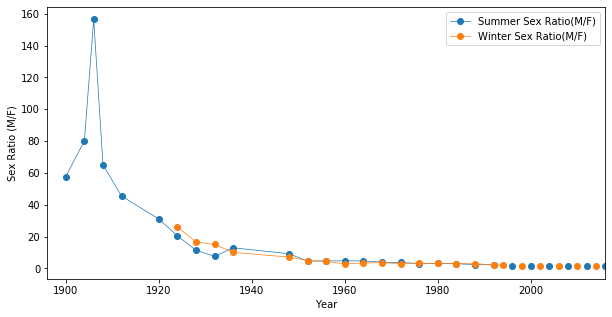

In [142]:
participants_by_year['Summer Sex Ratio(M/F)']=participants_by_year['Male Summer']/participants_by_year['Female Summer']
participants_by_year['Winter Sex Ratio(M/F)']=participants_by_year['Male Winter']/participants_by_year['Female Winter']
ax=participants_by_year.plot(kind='line',x='Year',y=['Summer Sex Ratio(M/F)','Winter Sex Ratio(M/F)'],marker='o',lw=0.7,figsize=(10,5))
ax.set_ylabel('Sex Ratio (M/F)')

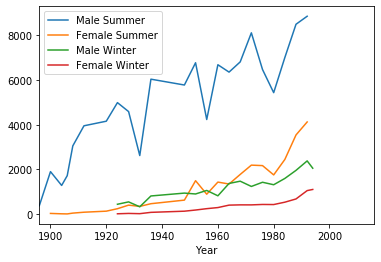

In [36]:
participants_by_year.plot(kind='line',x='Year',y=['Male Summer','Female Summer','Male Winter','Female Winter'])

In [37]:
medals_by_usa_over_years = pysqldf(
'''
SELECT Year
    ,SUM(CASE WHEN Season='Summer' THEN 1 ELSE 0 END) AS `USA Summer`
    ,SUM(CASE WHEN Season='Winter' THEN 1 ELSE 0 END) AS `USA Winter`
FROM df
WHERE NOC = 'USA'
GROUP BY Year
ORDER BY Year
''')
medals_by_usa_over_years.replace(0,np.nan,inplace=True)

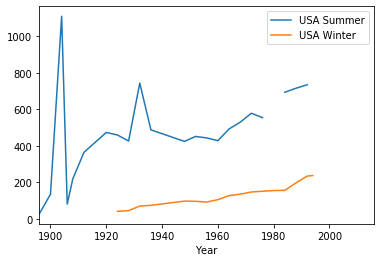

In [38]:
medals_by_usa_over_years.plot(kind='line',x='Year',y=['USA Summer','USA Winter'])

In [39]:
summer = pysqldf('''
SELECT df.Year AS Year
    ,COUNT(DISTINCT Sport) AS `Summer Sports`
    ,COUNT(DISTINCT Event) AS `Summer Events`
FROM df 
WHERE Season iS 'Summer'
GROUP BY df.Year
ORDER BY df.Year
''')
summer

,Year,Summer Sports,Summer Events
0,1896,9,43
1,1900,20,90
2,1904,18,95
3,1906,13,74
4,1908,24,109
5,1912,17,107
6,1920,25,158
7,1924,20,131
8,1928,17,122
9,1932,18,131


In [40]:
winter=pysqldf('''
SELECT Year
    ,COUNT(DISTINCT Sport) AS `Winter Sports`
    ,COUNT(DISTINCT Event) AS `Winter Events`
FROM df
WHERE Season IS 'Winter'
GROUP BY Year
ORDER BY Year
''')
winter

,Year,Winter Sports,Winter Events
0,1924,10,17
1,1928,8,14
2,1932,7,14
3,1936,8,17
4,1948,9,22
5,1952,8,22
6,1956,8,24
7,1960,8,27
8,1964,10,34
9,1968,10,35


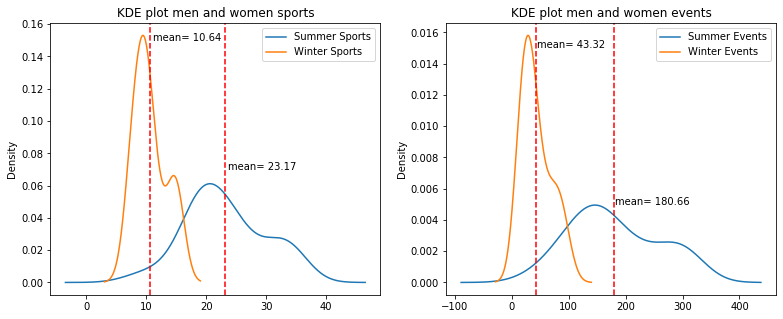

In [41]:
fig ,(ax1,ax2) = plt.subplots(1,2)
summer.plot(kind='kde',y='Summer Sports',figsize=(15,5),ax=ax1)
winter.plot(kind='kde',y=['Winter Sports'],ax=ax1)
_=ax1.axvline(summer['Summer Sports'].mean(),color='r',linestyle='dashed')
_=ax1.axvline(winter['Winter Sports'].mean(),color='r',linestyle='dashed')
_=ax1.annotate('mean= {:.02f}'.format(summer['Summer Sports'].mean()),(summer['Summer Sports'].mean()+0.5,0.07))
_=ax1.annotate('mean= {:.02f}'.format(winter['Winter Sports'].mean()),(winter['Winter Sports'].mean()+0.5,0.15))
_=ax1.set_title('KDE plot men and women sports')
summer.plot(kind='kde',y=['Summer Events'],figsize=(13,5),ax=ax2)
winter.plot(kind='kde',y=['Winter Events'],ax=ax2)
_=ax2.axvline(summer['Summer Events'].mean(),color='r',linestyle='dashed')
_=ax2.axvline(winter['Winter Events'].mean(),color='r',linestyle='dashed')
_=ax2.annotate('mean= {:.02f}'.format(summer['Summer Events'].mean()),(summer['Summer Events'].mean()+0.5,0.005))
_=ax2.annotate('mean= {:.02f}'.format(winter['Winter Events'].mean()),(winter['Winter Events'].mean()+0.5,0.015))
_=ax2.set_title('KDE plot men and women events')

In [42]:
_=ax2.annotate('mean= {:.02f}'.format(summer['Summer Events'].mean()),(summer['Summer Events'].mean()+0.5,0.07))
_=ax2.annotate('mean= {:.02f}'.format(winter['Winter Events'].mean()),(winter['Winter Events'].mean()+0.5,0.15))

In [43]:
summer.iloc[:,1:].agg(['mean','median','std'])

,Summer Sports,Summer Events
mean,23.172414,180.655172
median,23.000000,158.000000
std,6.535994,76.501296


In [44]:
winter.iloc[:,1:].agg(['mean','median'])

,Winter Sports,Winter Events
mean,10.636364,43.318182
median,10.000000,36.000000


In [150]:
def event_by_gender(eve):
    lis = eve.lower().split(' ')
    if "men's" in lis:
        return 'Men'
    elif "women's" in lis:
        return 'Women'
    elif "mixed" in lis:
        return 'Both'
    else: return 'Uncategorised'
df['Event By Gender'] = df['Event'].apply(lambda x: event_by_gender(x))

In [151]:
df['Event By Gender'].value_counts()

Men      182260
Women     71916
Both      16940
Name: Event By Gender, dtype: int64

In [47]:
event_by_gender_over_years = pysqldf('''
SELECT Year
    ,Men_Events
    ,Women_Events
    ,Men_Events*100/(Men_Events+Women_Events) AS Percent_men_events
    ,Women_Events*100/(Men_Events+Women_Events) AS Percent_women_events
FROM 
(SELECT Year
    ,SUM(CASE WHEN `Event By Gender` != 'Women' THEN 1 ELSE 0 END) AS Men_Events
    ,SUM(CASE WHEN `Event By Gender` != 'Men' THEN 1 ELSE 0 END) AS Women_Events
FROM df
GROUP BY Year ) temp
GROUP BY Year
ORDER BY Year 
''')
event_by_gender_over_years

,Year,Men_Events,Women_Events,Percent_men_events,Percent_women_events
0,1896,380,0,100,0
1,1900,1920,406,82,17
2,1904,1285,16,98,1
3,1906,1727,16,99,0
4,1908,3059,129,95,4
5,1912,3967,243,94,5
6,1920,4184,268,93,6
7,1924,5496,665,89,10
8,1928,5207,1329,79,20
9,1932,3117,1401,68,31


Text(0, 0.5, 'Event Count')

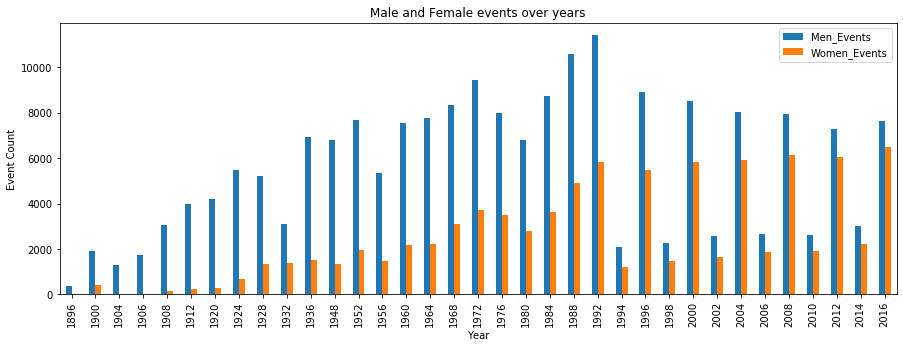

In [144]:
ax=event_by_gender_over_years.plot(kind='bar',x='Year',y=['Men_Events','Women_Events'],figsize=(15,5))
ax.set_title("Male and Female events over years")
ax.set_ylabel("Event Count")

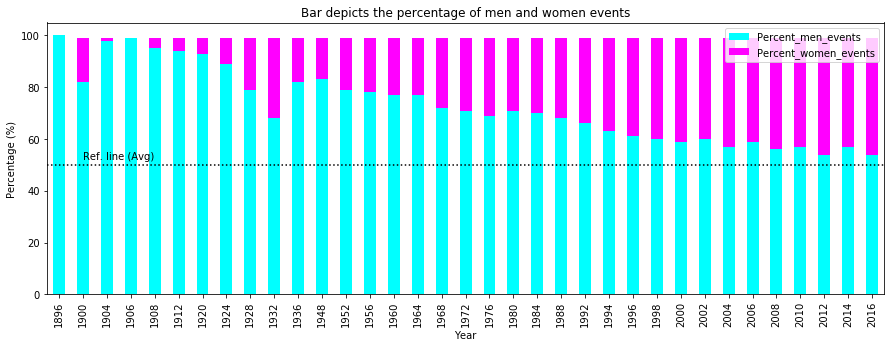

In [49]:
ax=event_by_gender_over_years.plot(kind='bar',x='Year',y=['Percent_men_events','Percent_women_events'],stacked=True,figsize=(15,5),cmap='cool')
ax.axhline(50,c='k',linestyle='dotted')
ax.annotate('Ref. line (Avg)',(1,52))
ax.set_title('Bar depicts the percentage of men and women events')
_=ax.set_ylabel('Percentage (%)')

In [156]:
ratio_events =pysqldf('''
SELECT Year
    ,SUM(CASE WHEN `Event By Gender`!='Women' AND Season='Summer' THEN 1 ELSE 0 END) AS `Male Summer`
    ,SUM(CASE WHEN `Event By Gender`!='Women' AND Season='Winter' THEN 1 ELSE 0 END) AS `Male Winter`
    ,SUM(CASE WHEN `Event By Gender`!='Men' AND Season='Summer' THEN 1 ELSE 0 END) AS `Female Summer`
    ,SUM(CASE WHEN `Event By Gender`!='Men' AND Season='Winter' THEN 1 ELSE 0 END) AS `Female Winter`
FROM df
GROUP BY Year
ORDER BY Year
''')
ratio_events

,Year,Male Summer,Male Winter,Female Summer,Female Winter
0,1896,380,0,0,0
1,1900,1920,0,406,0
2,1904,1285,0,16,0
3,1906,1727,0,16,0
4,1908,3059,0,129,0
5,1912,3967,0,243,0
6,1920,4184,0,268,0
7,1924,5044,452,618,47
8,1928,4645,562,1283,46
9,1932,2780,337,1372,29


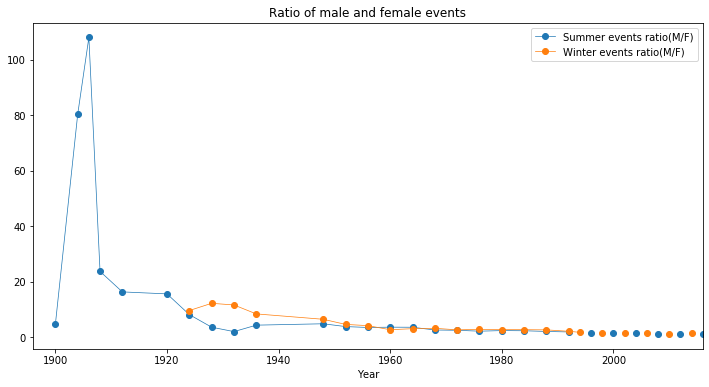

In [162]:
ratio_events['Summer events ratio(M/F)'] = ratio_events['Male Summer']/ratio_events['Female Summer']
ratio_events['Winter events ratio(M/F)'] = ratio_events['Male Winter']/ratio_events['Female Winter']
ratio_events.plot(kind='line',x='Year',y=['Summer events ratio(M/F)','Winter events ratio(M/F)'],lw=0.7,marker='o',title='Ratio of male and female events',figsize=(12,6))


In [50]:
winter_after_1992 = pysqldf('''
SELECT Year
    ,SUM(CASE WHEN Sex='M' THEN 1 ELSE 0 END) AS `Male Winter`
    ,SUM(CASE WHEN Sex='F' THEN 1 ELSE 0 END) AS `Female Winter`
FROM df
WHERE Year>1992 AND Season IS 'Winter'
GROUP BY Year
ORDER BY Year
''')
winter_after_1992

,Year,Male Winter,Female Winter
0,1994,2055,1105
1,1998,2221,1384
2,2002,2527,1582
3,2006,2625,1757
4,2010,2555,1847
5,2014,2868,2023


In [51]:
winter_after_1992.drop(5,inplace=True) #dropping last column to predict

In [52]:
from sklearn.linear_model import LinearRegression
regressor1 = LinearRegression()
regressor1.fit(winter_after_1992['Year'].to_numpy().reshape(-1,1),winter_after_1992['Male Winter'].to_numpy().reshape(-1,1))
regressor2 = LinearRegression()
regressor2.fit(winter_after_1992['Year'].to_numpy().reshape(-1,1),winter_after_1992['Female Winter'].to_numpy().reshape(-1,1))
print('Number of male expected in 2014 winter olympics is ',regressor1.predict(np.array([[2016]]))[0][0])
print('Number of female expected in 2014 winter olympics is ',regressor2.predict(np.array([[2016]]))[0][0])
print('Number of male expected in 2018 winter olympics is ',regressor1.predict(np.array([[2018]]))[0][0])
print('Number of female expected in 2018 winter olympics is ',regressor2.predict(np.array([[2018]]))[0][0])

Number of male expected in 2014 winter olympics is  2888.0000000000146
Number of female expected in 2014 winter olympics is  2184.949999999997
Number of male expected in 2018 winter olympics is  2958.2000000000116
Number of female expected in 2018 winter olympics is  2277.800000000003


# Predicting the number of participants in year 2014 from the previous years.  

Predicted number of male participants in 2014 = 2888  
Actual number of male participants in 2014    = 2868  
                                    __Error__ = _20_

Predicted number of female participants in 2014 = 2184  
Actual number of female participants in 2014    = 2023  
                                    __Error__   = _161_

Text(0, 0.5, 'Participants')

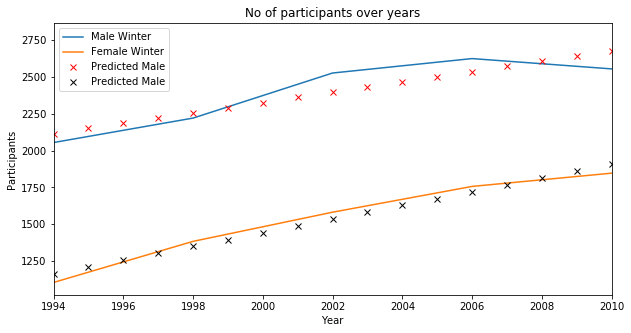

In [53]:
ax=winter_after_1992.plot.line(x='Year',y=['Male Winter','Female Winter'],figsize=(10,5))
ax.plot(np.arange(1994,2014).reshape(-1,1),regressor1.predict(np.arange(1994,2014).reshape(-1,1)),'x',c='r',label='Predicted Male')
ax.plot(np.arange(1994,2014).reshape(-1,1),regressor2.predict(np.arange(1994,2014).reshape(-1,1)),'x',c='k',label='Predicted Male')
ax.legend()
ax.set_title('No of participants over years')
ax.set_ylabel('Participants')

In [54]:
men_corr=event_by_gender_over_years['Men_Events'].corr(participants_by_year['Male Summer']+participants_by_year['Male Winter'])
women_corr=event_by_gender_over_years['Women_Events'].corr(participants_by_year['Female Summer']+participants_by_year['Female Winter'])

print("Corelation between participants and events for men over each year is ",men_corr)
print("Corelation between participants and events for women over each year is ",women_corr)

Corelation between participants and events for men over each year is  0.9997512333242972
Corelation between participants and events for women over each year is  0.983446945772769


## Correlation between number of participants and number of events each year
Correlation between participants and events for men over each year is  __0.9997512333242972__   
Correlation between participants and events for women over each year is __0.983446945772769__

The above correlation values show that there is a heavy correlation between a number of participants and number of events as when people are more willing to participate, the event management committee adds more and more events to get the best out them. If there are more events and fewer participants, then many events are empty causes revenue loss for maintaining events and in the other case of more participants and fewer events, even though all events are full many participants didn't even get a chance to participate.

In [55]:
total_medals=medals_by_country['Total Count'].sum()
percent_medals = medals_by_country.loc[:,['region','Total Count']].head(10)
percent_medals=percent_medals.append(pd.DataFrame([{'region':'Other','Total Count':total_medals-percent_medals['Total Count'].sum()}]))
percent_medals.rename(columns={'region':'Country','Total Count':'Medals'},inplace=True)
percent_medals['Percentage'] = percent_medals['Medals'].apply(lambda x: x*100/total_medals)
percent_medals.set_index('Country',inplace=True)
percent_medals.drop(columns='Medals',inplace=True)

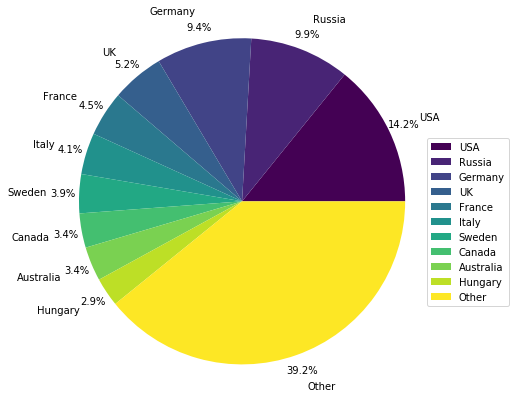

In [56]:
ax=percent_medals.plot.pie(y='Percentage',autopct='%.1f%%',pctdistance=1.1, labeldistance=1.2,radius=1.5,figsize=(5,5),cmap='viridis')
_=ax.set_ylabel(' ',visible=False)
_=ax.legend(bbox_to_anchor=(1.5,0.75))

In [57]:
medals_by_country.head(10)

,region,NOC,Gold,Silver,Bronze,Total Count
0,USA,USA,2638,1641,1358,5637
1,Russia,RUS,1599,1170,1178,3947
2,Germany,GDR,1301,1195,1260,3756
3,UK,GBR,678,739,651,2068
4,France,FRA,501,610,666,1777
5,Italy,ITA,575,531,531,1637
6,Sweden,SWE,479,522,535,1536
7,Canada,CAN,463,438,451,1352
8,Australia,AUS,368,459,522,1349
9,Hungary,HUN,432,332,371,1135


In [58]:
olympics_city =pysqldf('''
SELECT Year
    ,Season
    ,City
FROM df
WHERE Year IS 1956 AND Season = 'Summer'
GROUP BY Year,Season,City
ORDER BY Year
''')
olympics_city

,Year,Season,City
0,1956,Summer,Melbourne
1,1956,Summer,Stockholm


In [163]:
country_trends = pysqldf('''
SELECT Year
    ,COUNT(DISTINCT NOC) AS count
FROM df
GROUP BY Year
    ''')
country_trends

,Year,count
0,1896,12
1,1900,31
2,1904,15
3,1906,21
4,1908,22
5,1912,29
6,1920,29
7,1924,46
8,1928,46
9,1932,47
